In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import os
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import joblib 
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import optuna

In [17]:
data = pd.read_csv('housing_all.csv')
data = data.drop(columns=['Unnamed: 0','town','storey_range','flat_model','district'])

In [18]:
data.head()


,year,month,flat_type,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,range_numeric
0,1990,1,1 ROOM,31.0,1977,86,9000.0,11.0
1,1990,1,1 ROOM,31.0,1977,86,6000.0,5.0
2,1990,1,1 ROOM,31.0,1977,86,8000.0,11.0
3,1990,1,1 ROOM,31.0,1977,86,6000.0,8.0
4,1990,1,3 ROOM,73.0,1976,85,47200.0,5.0


In [19]:
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))
data.sort_values(by='date', inplace=True)  # Sort by time
data.drop(columns=['year', 'month'])

,flat_type,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,range_numeric,date
0,1 ROOM,31.0,1977,86,9000.0,11.0,1990-01-01
1010,3 ROOM,63.0,1981,90,31400.0,5.0,1990-01-01
1009,3 ROOM,67.0,1984,93,66500.0,5.0,1990-01-01
1008,3 ROOM,103.0,1984,93,77000.0,5.0,1990-01-01
1007,3 ROOM,68.0,1982,91,58000.0,2.0,1990-01-01
...,...,...,...,...,...,...,...
939683,4 ROOM,90.0,2003,78,572000.0,11.0,2024-11-01
939682,4 ROOM,93.0,2019,94,680000.0,11.0,2024-11-01
939681,4 ROOM,93.0,2019,94,590000.0,2.0,2024-11-01
939679,4 ROOM,93.0,2019,94,600000.0,2.0,2024-11-01


In [21]:
data = data[['date','flat_type','range_numeric','floor_area_sqm','lease_commence_date','remaining_lease','resale_price']]

In [22]:
data.head()

,date,flat_type,range_numeric,floor_area_sqm,lease_commence_date,remaining_lease,resale_price
0,1990-01-01,1 ROOM,11.0,31.0,1977,86,9000.0
1010,1990-01-01,3 ROOM,5.0,63.0,1981,90,31400.0
1009,1990-01-01,3 ROOM,5.0,67.0,1984,93,66500.0
1008,1990-01-01,3 ROOM,5.0,103.0,1984,93,77000.0
1007,1990-01-01,3 ROOM,2.0,68.0,1982,91,58000.0


In [23]:
data.groupby(['date','flat_type','lease_commence_date','remaining_lease'])
data.head()



,date,flat_type,range_numeric,floor_area_sqm,lease_commence_date,remaining_lease,resale_price
0,1990-01-01,1 ROOM,11.0,31.0,1977,86,9000.0
1010,1990-01-01,3 ROOM,5.0,63.0,1981,90,31400.0
1009,1990-01-01,3 ROOM,5.0,67.0,1984,93,66500.0
1008,1990-01-01,3 ROOM,5.0,103.0,1984,93,77000.0
1007,1990-01-01,3 ROOM,2.0,68.0,1982,91,58000.0


In [24]:
data.info

<bound method DataFrame.info of              date  flat_type  range_numeric  floor_area_sqm  \
0      1990-01-01     1 ROOM           11.0            31.0   
1010   1990-01-01     3 ROOM            5.0            63.0   
1009   1990-01-01     3 ROOM            5.0            67.0   
1008   1990-01-01     3 ROOM            5.0           103.0   
1007   1990-01-01     3 ROOM            2.0            68.0   
...           ...        ...            ...             ...   
939683 2024-11-01     4 ROOM           11.0            90.0   
939682 2024-11-01     4 ROOM           11.0            93.0   
939681 2024-11-01     4 ROOM            2.0            93.0   
939679 2024-11-01     4 ROOM            2.0            93.0   
940738 2024-11-01  EXECUTIVE            2.0           142.0   

        lease_commence_date  remaining_lease  resale_price  
0                      1977               86        9000.0  
1010                   1981               90       31400.0  
1009                   1984 

In [28]:
data.dtypes

date                   datetime64[ns]
flat_type                      object
range_numeric                 float64
floor_area_sqm                float64
lease_commence_date             int64
remaining_lease                 int64
resale_price                  float64
dtype: object

In [33]:
columns_to_normalize = ['range_numeric']

# Apply StandardScaler
scaler = StandardScaler()
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

In [34]:
for flat_type in data['flat_type'].unique():
  
    # Initialize an empty list to collect rows
    rows = []

    # Iterate through each row in the DataFrame
    for _, row in data.iterrows():
        if row['flat_type'] == flat_type:
            # Add the row to the list
            rows.append(row)

    # Convert the list of rows to a DataFrame
    df = pd.DataFrame(rows)
    df.to_csv(f'Forecast/{flat_type}.csv', index=False)


In [37]:
data_list = os.listdir('Forecast')

for data in data_list:

    df = pd.read_csv(f'Forecast/{data}')
    df['date'] = pd.to_datetime(df['date'])
    #df = df.drop(columns=['flat_type'])
    columns_to_normalize = ['floor_area_sqm', 'remaining_lease']

    # Apply StandardScaler
    scaler = StandardScaler()
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    # Check the transformed dat
    df.to_csv(f'Forecast/{data}')


In [39]:
data_list = os.listdir('Forecast')
for data in data_list:

    df = pd.read_csv(f'Forecast/{data}')
    df = df.drop(columns=['Unnamed: 0'])

    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Extract the year and month for grouping
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    # Calculate the monthly median resale price for each month
    monthly_median = df.groupby(['year', 'month'])['resale_price'].median().reset_index()
    monthly_median.rename(columns={'resale_price': 'monthly_median_price'}, inplace=True)

    # Merge the median price back to the original dataframe
    df = pd.merge(df, monthly_median, on=['year', 'month'], how='left')

    # Lag features based on monthly median resale prices
    df['lag_1'] = df.groupby(['year', 'month'])['monthly_median_price'].shift(1)  # 1-month lag
    df['lag_2'] = df.groupby(['year', 'month'])['monthly_median_price'].shift(2)  # 2-month lag
    df['lag_3'] = df.groupby(['year', 'month'])['monthly_median_price'].shift(3)  # 3-month lag

    # Rolling statistics based on resale price
    df['rolling_mean_3'] = df['resale_price'].rolling(window=3).mean()
    df['rolling_std_3'] = df['resale_price'].rolling(window=3).std()

    # Drop rows with NaN values due to lagging or rolling
    df.dropna(inplace=True)

    # Drop the year and month columns if not needed anymore
    df.drop(columns=['year', 'month'], inplace=True)

    # Save the transformed dataframe
    df.to_csv(f'Forecast/{data}')


Model performance for 1 ROOM.csv:
Mean Absolute Error: 11918.929197994988
Mean Squared Error: 886353183.7851026
R-squared: 0.5000488362330398




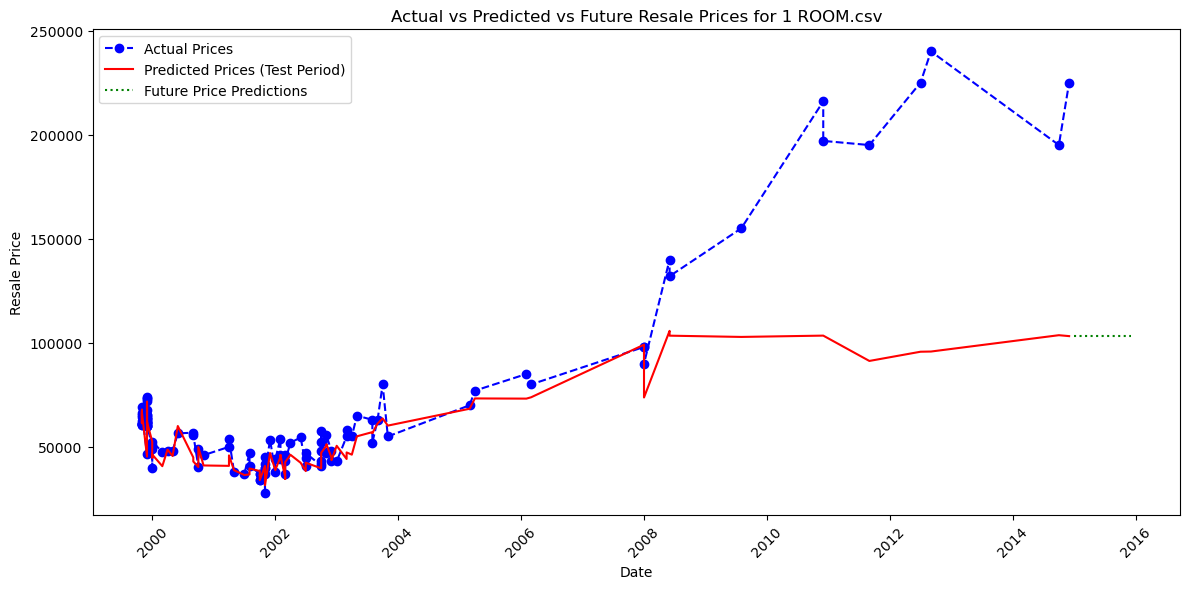

Model performance for 2 ROOM.csv:
Mean Absolute Error: 32149.31659070191
Mean Squared Error: 1781878591.2433102
R-squared: 0.25729478265788663




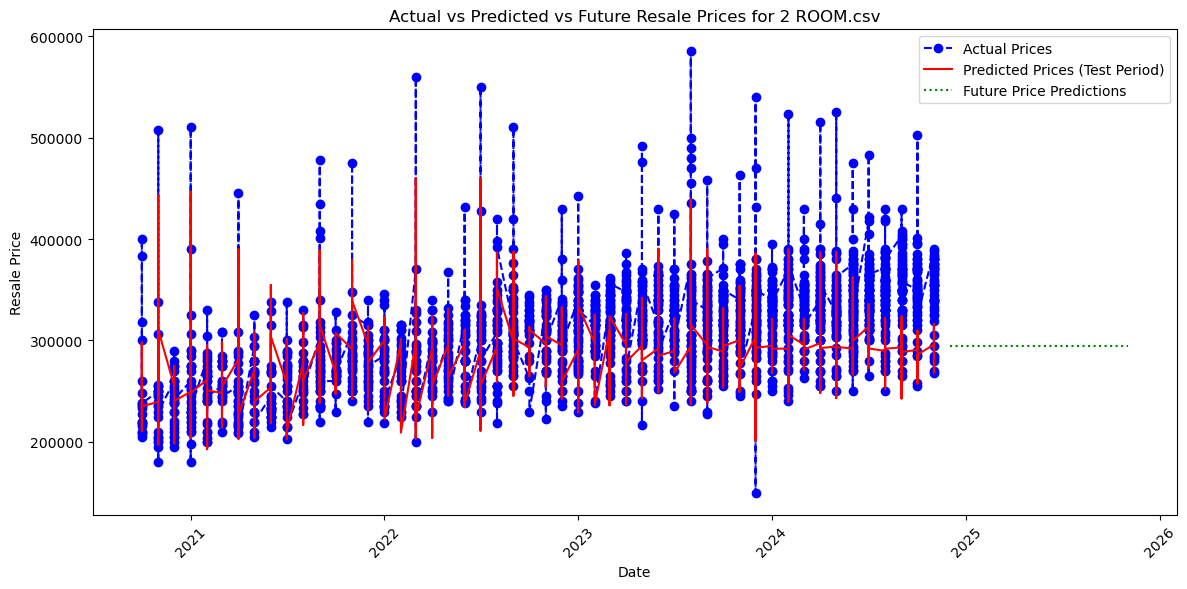

Model performance for 3 ROOM.csv:
Mean Absolute Error: 21881.99099445258
Mean Squared Error: 1820400328.2820575
R-squared: 0.777931193588681




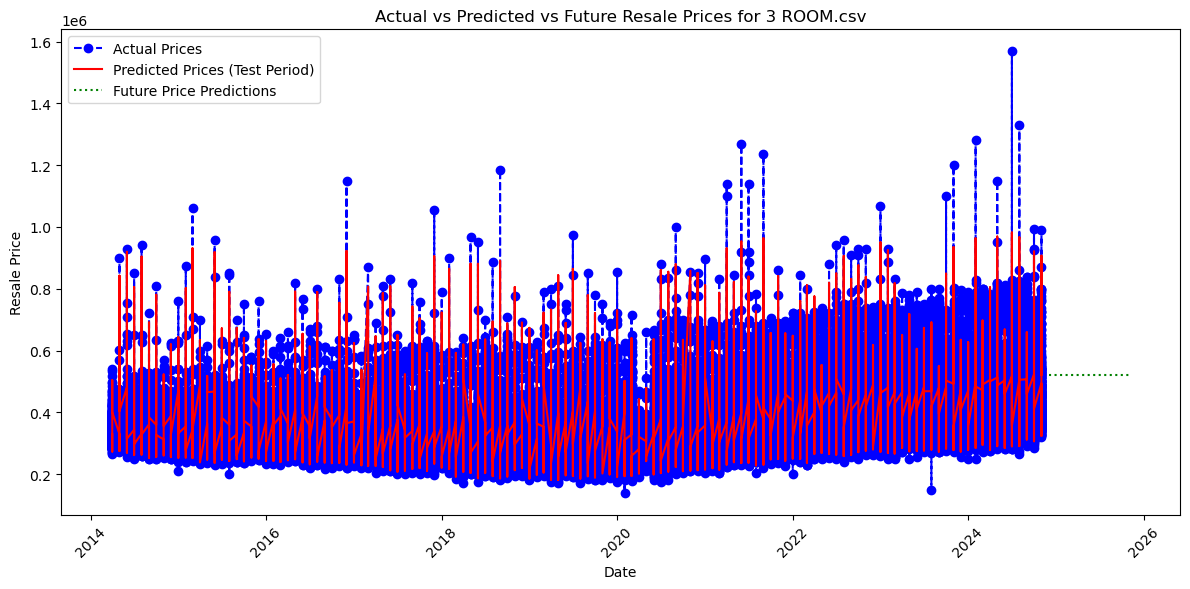

Model performance for 4 ROOM.csv:
Mean Absolute Error: 30084.10087586768
Mean Squared Error: 2843475301.4304867
R-squared: 0.8694444491291384




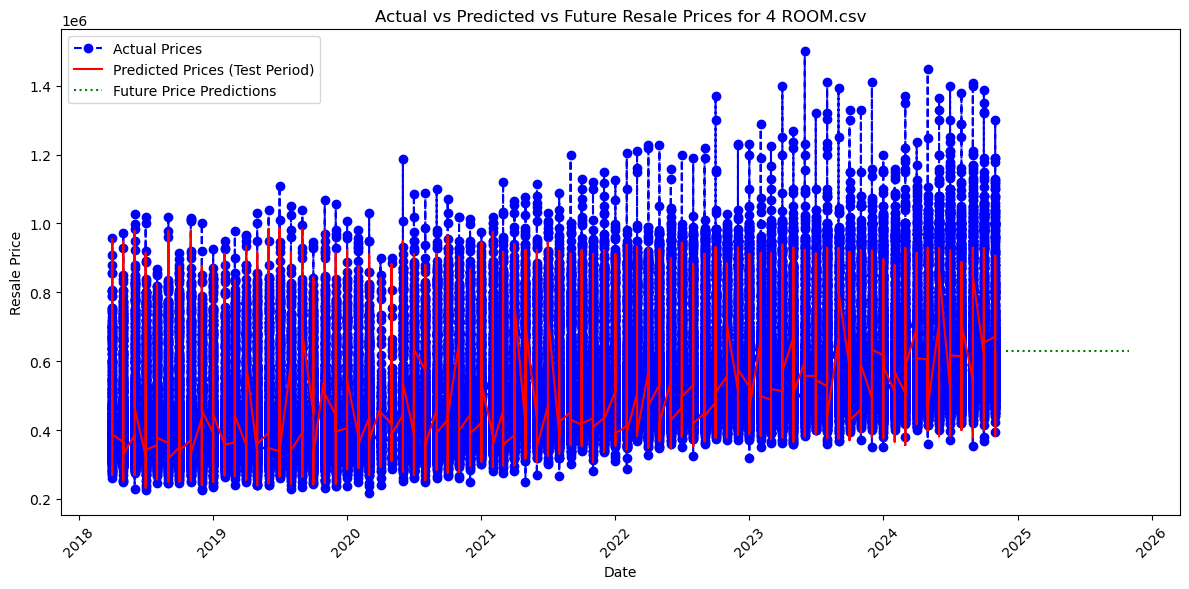

In [ ]:
data_list = os.listdir('Forecast')
# List of data files (assuming you already have a list of CSV file names)
for data in data_list:
    # Read the dataset
    df = pd.read_csv(f'Forecast/{data}')
    df['date'] = pd.to_datetime(df['date'])
    df = df[['date','range_numeric', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 
            'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3','resale_price']]
    
    train_size = int(len(df) * 0.8)  # 80% for training
    train = df[:train_size]
    test = df[train_size:]
    
    # Prepare training and testing sets
    X_train = train[['range_numeric', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 
                          'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']]
    y_train = train['resale_price']
    
    X_test = test[['range_numeric', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 
                        'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']]
    y_test = test['resale_price']

    # Initialize and train the RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Model performance for {data}:")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print("\n")

    # Now let's predict future prices (for months beyond the test period)
    # Create a DataFrame with the last date in the test set for forecasting future months
    future_dates = pd.date_range(start=test['date'].max() + pd.Timedelta(days=30), 
                                 periods=12, freq='MS')  # Example: predicting next 12 months
    
    # Create a dummy DataFrame with the same feature columns for future months
    future_data = pd.DataFrame({
        'range_numeric': [test['range_numeric'].iloc[-1]] * 12,
        'floor_area_sqm': [test['floor_area_sqm'].iloc[-1]] * 12,
        'lease_commence_date': [test['lease_commence_date'].iloc[-1]] * 12,
        'remaining_lease': [test['remaining_lease'].iloc[-1]] * 12,
        'lag_1': [test['lag_1'].iloc[-1]] * 12,
        'lag_2': [test['lag_2'].iloc[-1]] * 12,
        'lag_3': [test['lag_3'].iloc[-1]] * 12,
        'rolling_mean_3': [test['rolling_mean_3'].iloc[-1]] * 12,
        'rolling_std_3': [test['rolling_std_3'].iloc[-1]] * 12,
    })
    future_data['date'] = future_dates
    
    # Make future price predictions
    future_predictions = model.predict(future_data[['range_numeric', 'floor_area_sqm', 'lease_commence_date', 
                                                     'remaining_lease', 'lag_1', 'lag_2', 'lag_3', 
                                                     'rolling_mean_3', 'rolling_std_3']])

    # Plot the actual vs predicted prices, including future predictions
    plt.figure(figsize=(12, 6))
    
    # Plot actual prices
    plt.plot(test['date'], y_test, label='Actual Prices', color='blue', marker='o', linestyle='dashed')

    # Plot predicted prices for the test period
    plt.plot(test['date'], y_pred, label='Predicted Prices (Test Period)', color='red', linestyle='solid')

    # Plot future price predictions
    plt.plot(future_data['date'], future_predictions, label='Future Price Predictions', color='green', linestyle='dotted')

    # Adding title and labels
    plt.title(f'Actual vs Predicted vs Future Resale Prices for {data}')
    plt.xlabel('Date')
    plt.ylabel('Resale Price')
    plt.legend()

    # Rotate date labels for better visibility
    plt.xticks(rotation=45)

    # Display the plot
    plt.tight_layout()
    plt.show()
